Loading embeddings from: ./embeddings/final_embeddings_molecules_20250309_101416.pkl
Loaded 41 embeddings
Extracting graph properties...
Preparing property matrix...
Reducing dimensionality with UMAP...


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Rebuilding molecules from graph data...
Successfully rebuilt 41 molecules
Clustering embeddings...
Finding representative molecules for each cluster...
Calculating molecular properties...
Creating cluster-based visualization...
Visualization saved to: ./visualization_files\clustered_embedding.png
Creating additional visualizations...
Visualization saved to: ./visualization_files\clustered_embedding_logp.png
Visualization saved to: ./visualization_files\clustered_embedding_n_rings.png
Saving cluster information...
Saved cluster information to ./visualization_files\cluster_info.json
Cluster visualization complete! Now run the molecule rendering script.


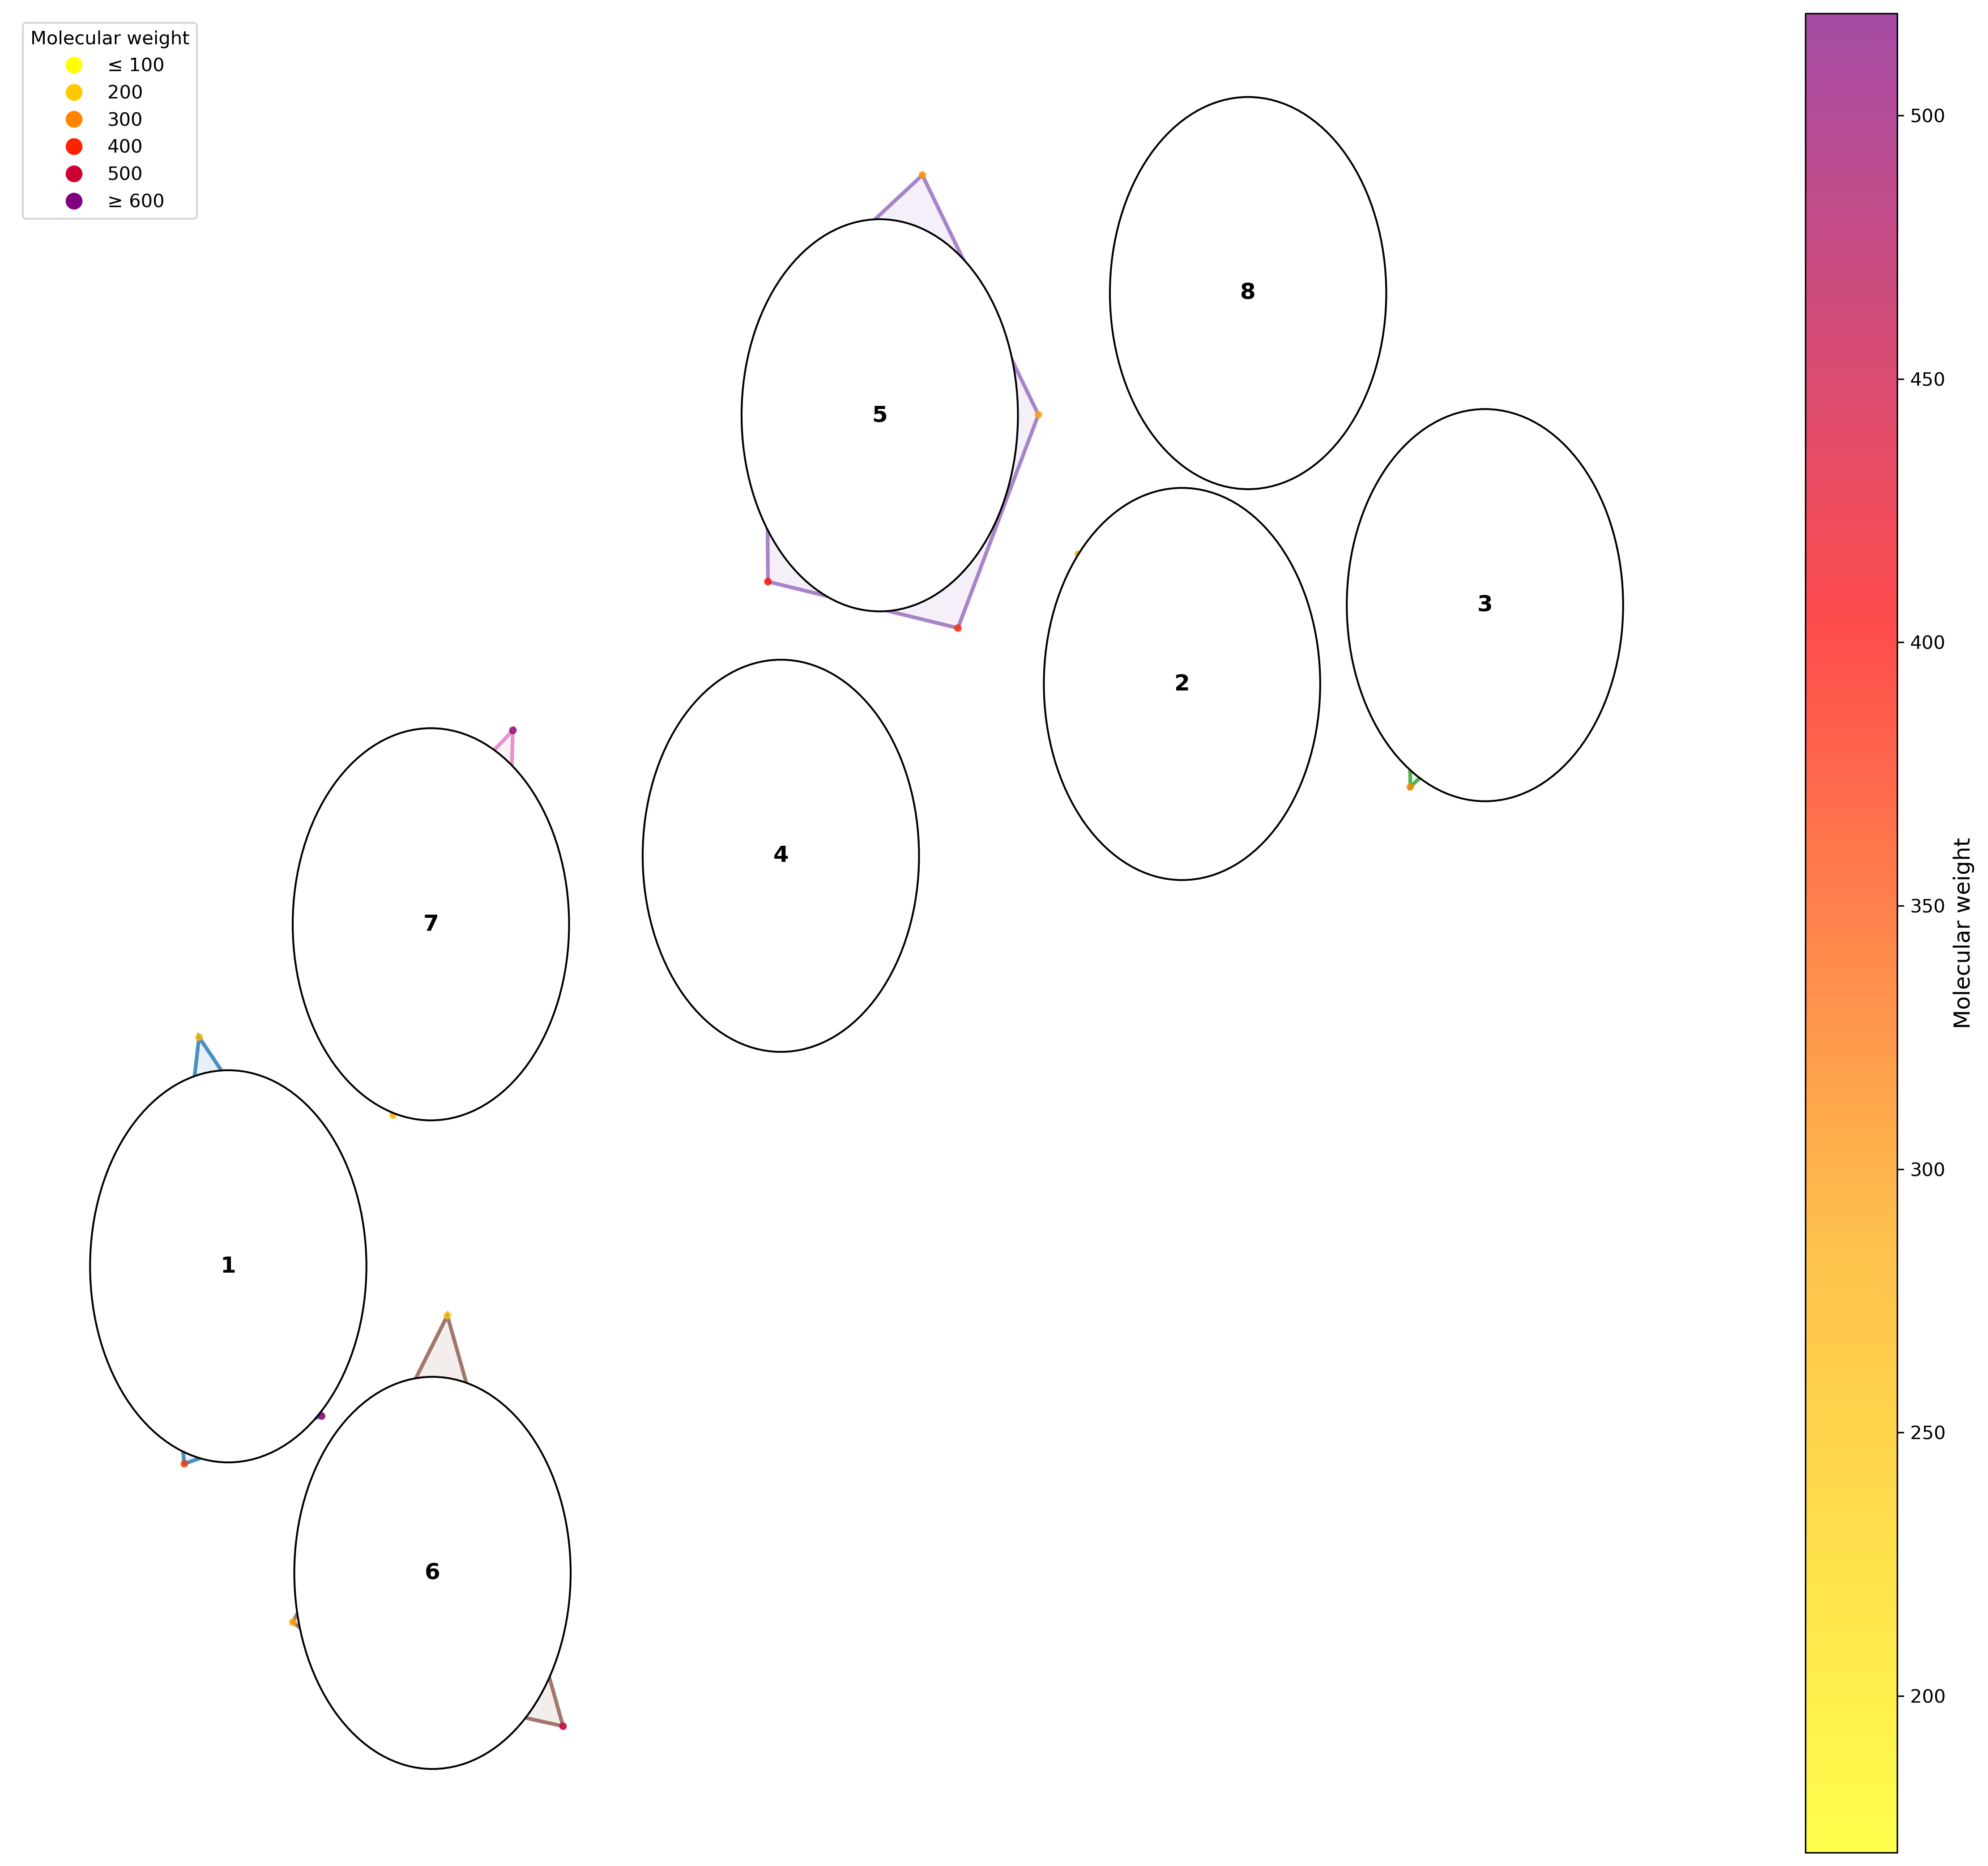

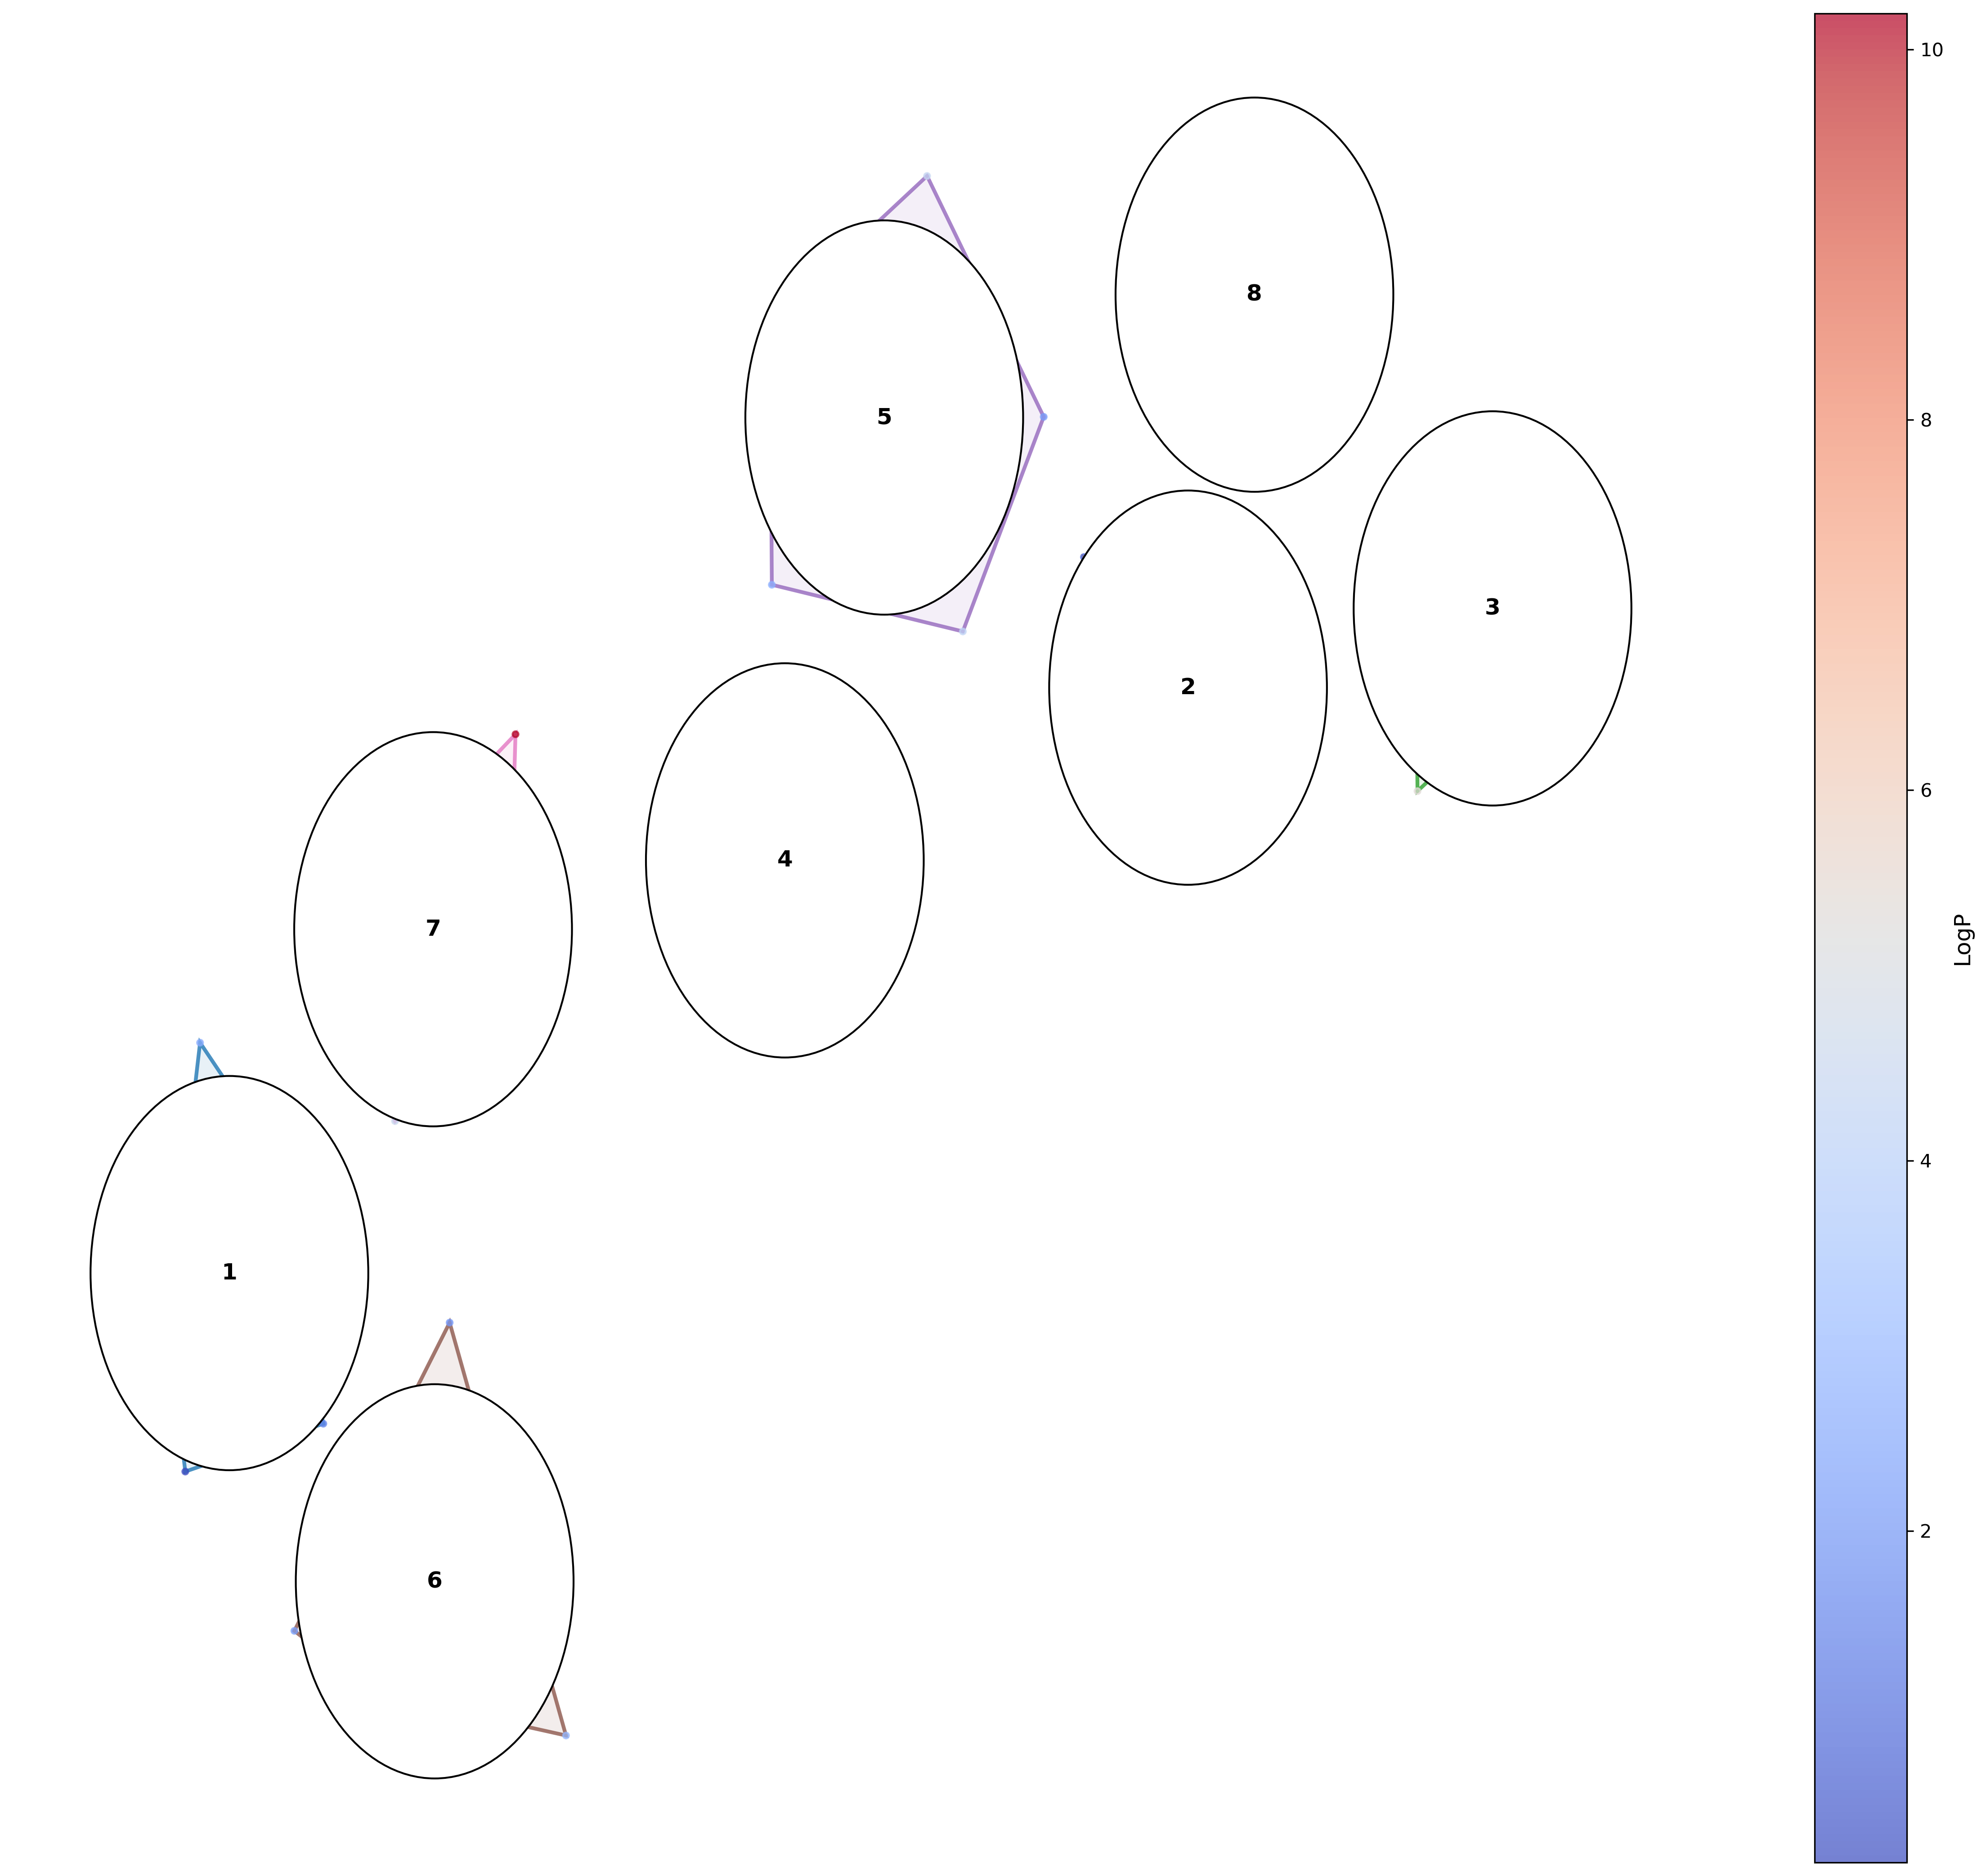

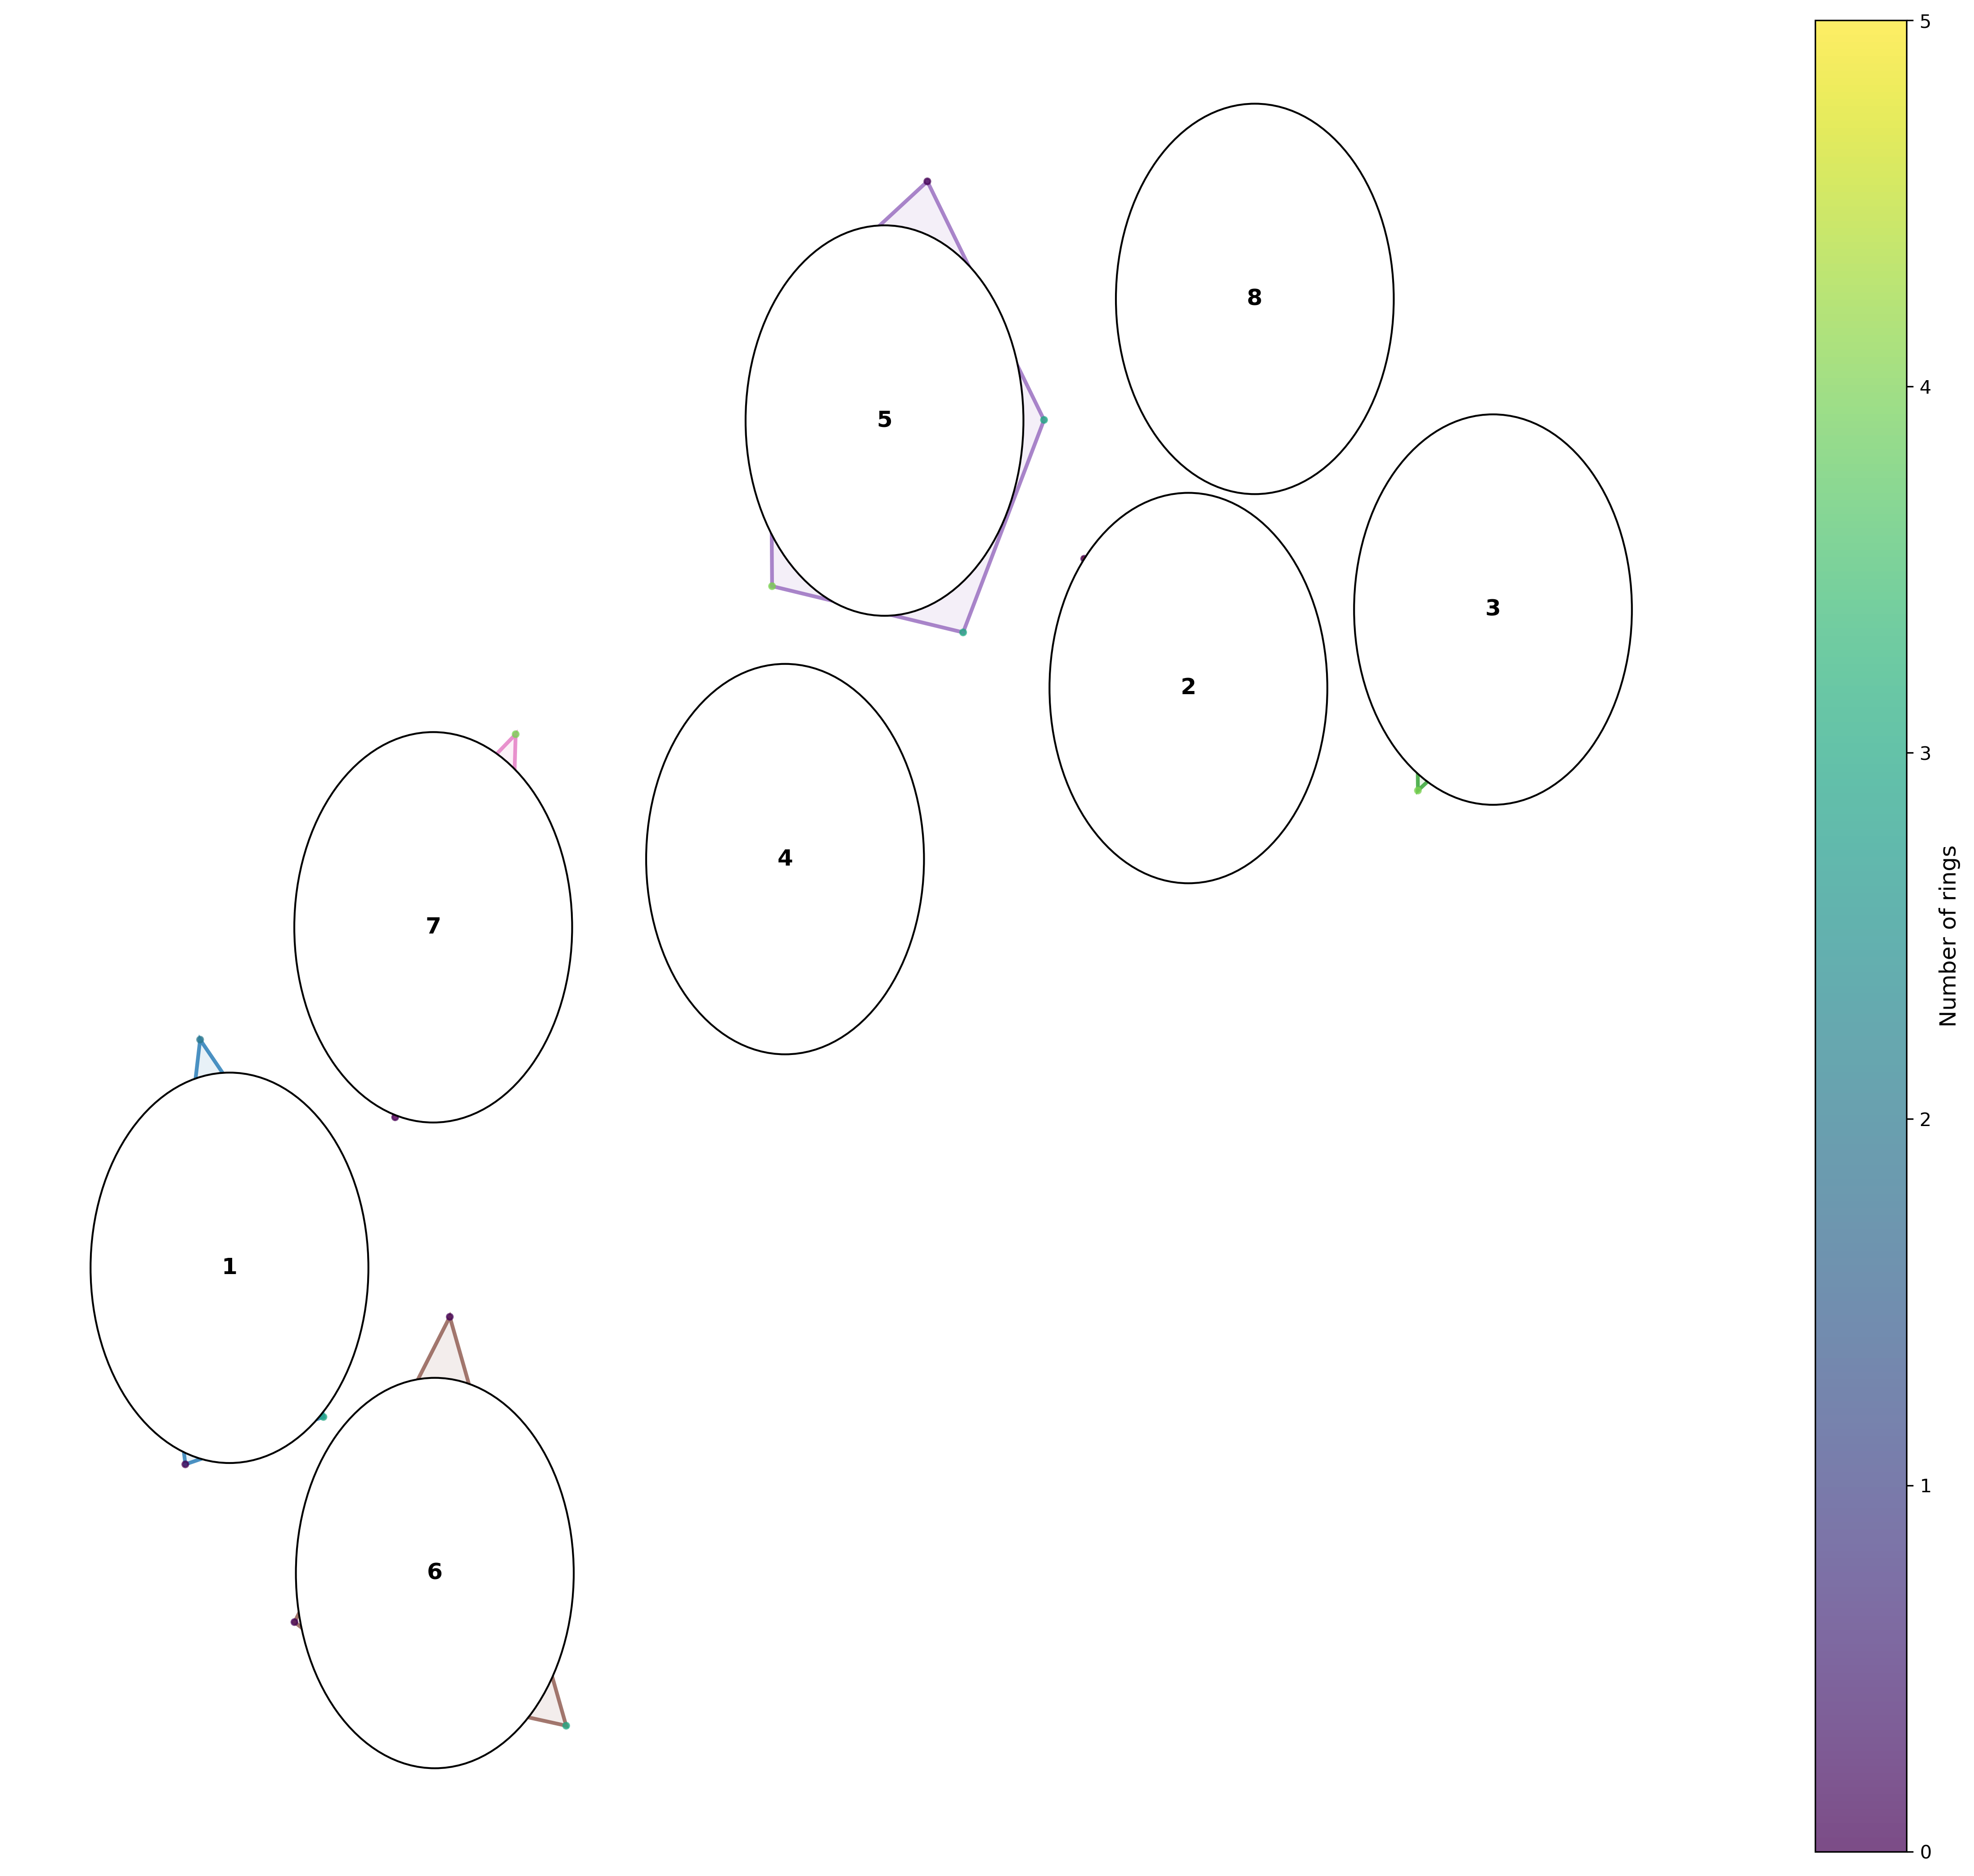

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon, Circle
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, AllChem
import os
import json
from matplotlib.lines import Line2D
from rdkit import RDLogger
from scipy.spatial import ConvexHull
import matplotlib.cm as cm
from collections import Counter, defaultdict

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data

def extract_graph_properties(molecule_data):
    """Extract graph-level properties from molecule data"""
    properties = []
    
    for mol_data in molecule_data:
        # Basic graph properties
        prop = {}
        
        # Number of nodes
        prop['num_nodes'] = mol_data.get('num_nodes', 0)
        
        # Edge count (divide by 2 for undirected graphs)
        if mol_data.get('edge_index') is not None:
            edge_count = len(mol_data['edge_index'][0]) // 2
            prop['edge_count'] = edge_count
        else:
            prop['edge_count'] = 0
        
        # Graph density
        prop['graph_density'] = mol_data.get('graph_density', 0)
        
        # Average degree
        prop['avg_degree'] = mol_data.get('avg_degree', 0)
        
        # Extract atom type distribution if available
        atom_counts = defaultdict(int)
        if mol_data.get('x_cat') is not None:
            for atom in mol_data['x_cat']:
                atom_type = atom[0]
                atom_counts[atom_type] += 1
                
            # Calculate proportions of common atom types
            total_atoms = sum(atom_counts.values())
            if total_atoms > 0:
                for atom_type in [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]:  # H, C, N, O, F, P, S, Cl, Br, I
                    prop[f'atom_{atom_type}_ratio'] = atom_counts[atom_type] / total_atoms
        
        # Extract bond type distribution if available
        if mol_data.get('edge_attr') is not None:
            bond_counts = Counter([int(bond[0]) for bond in mol_data['edge_attr']])
            total_bonds = sum(bond_counts.values()) // 2  # Divide by 2 for undirected
            
            if total_bonds > 0:
                for bond_type in range(4):  # Single, double, triple, aromatic
                    prop[f'bond_{bond_type}_ratio'] = bond_counts[bond_type] / (total_bonds * 2)
        
        properties.append(prop)
    
    return properties

def properties_to_matrix(properties):
    """Convert properties dictionary list to a matrix for clustering"""
    # Define the properties to use
    property_keys = [
        'num_nodes', 'edge_count', 'graph_density', 'avg_degree',
        'atom_1_ratio', 'atom_6_ratio', 'atom_7_ratio', 'atom_8_ratio',
        'atom_9_ratio', 'atom_15_ratio', 'atom_16_ratio', 'atom_17_ratio',
        'bond_0_ratio', 'bond_1_ratio', 'bond_2_ratio', 'bond_3_ratio'
    ]
    
    # Create matrix
    matrix = []
    for prop in properties:
        row = []
        for key in property_keys:
            # Use 0 if property is missing
            row.append(prop.get(key, 0))
        matrix.append(row)
    
    return np.array(matrix)

def reduce_dimensions(embeddings, method='umap', n_components=2, **kwargs):
    """Reduce dimensionality of embeddings for visualization"""
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

def rebuild_molecules_from_graph_data(molecule_data_list):
    """Reconstruct RDKit molecules from graph data - simplified version"""
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    molecules = []
    valid_count = 0
    
    for mol_data in molecule_data_list:
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(None)
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if start >= mol.GetNumAtoms() or end >= mol.GetNumAtoms():
                    continue
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                    
                # Add the bond
                try:
                    bond_type_idx = int(edge_attr[i][0])
                    if bond_type_idx < len(bond_list):
                        bond_type = bond_list[bond_type_idx]
                        mol.AddBond(start, end, bond_type)
                        processed_edges.add((start, end))
                except Exception:
                    continue
            
            # Convert to molecule
            try:
                final_mol = Chem.Mol(mol)
                for atom in final_mol.GetAtoms():
                    atom.UpdatePropertyCache(strict=False)
                
                # Try to sanitize with error catching
                try:
                    Chem.SanitizeMol(final_mol)
                except:
                    pass
                    
                # Compute 2D coordinates
                AllChem.Compute2DCoords(final_mol)
                
                molecules.append(final_mol)
                valid_count += 1
            except Exception:
                molecules.append(None)
                
        except Exception:
            molecules.append(None)
    
    print(f"Successfully rebuilt {valid_count} molecules")
    return molecules

def cluster_embeddings(embeddings_2d, n_clusters=8):
    """Cluster embeddings using KMeans"""
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings_2d)
    
    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return clusters, centers

def find_cluster_representatives(embeddings_2d, clusters, molecules, n_per_cluster=3):
    """Find representative molecules for each cluster"""
    unique_clusters = np.unique(clusters)
    representatives = {}
    
    for cluster_id in unique_clusters:
        # Get indices of molecules in this cluster
        cluster_indices = np.where(clusters == cluster_id)[0]
        
        # Filter for valid molecules
        valid_indices = [idx for idx in cluster_indices if idx < len(molecules) and molecules[idx] is not None]
        
        if not valid_indices:
            continue
            
        # Get cluster center
        cluster_points = embeddings_2d[cluster_indices]
        center = np.mean(cluster_points, axis=0)
        
        # Find closest molecules to center
        distances = np.sqrt(np.sum((embeddings_2d[valid_indices] - center)**2, axis=1))
        closest_indices = np.argsort(distances)[:n_per_cluster]
        
        # Get the actual indices in the original dataset
        representative_indices = [valid_indices[i] for i in closest_indices]
        
        representatives[cluster_id] = representative_indices
    
    return representatives

def calculate_molecular_properties(molecules):
    """Calculate various molecular properties"""
    properties = {}
    
    # Molecular weight
    weights = []
    for mol in molecules:
        if mol is None:
            weights.append(0)
        else:
            try:
                weights.append(Descriptors.MolWt(mol))
            except:
                weights.append(0)
                
    properties['weight'] = np.array(weights)
    
    # LogP (lipophilicity)
    logp = []
    for mol in molecules:
        if mol is None:
            logp.append(0)
        else:
            try:
                logp.append(Descriptors.MolLogP(mol))
            except:
                logp.append(0)
                
    properties['logp'] = np.array(logp)
    
    # Number of rings
    n_rings = []
    for mol in molecules:
        if mol is None:
            n_rings.append(0)
        else:
            try:
                n_rings.append(Descriptors.RingCount(mol))
            except:
                n_rings.append(0)
                
    properties['n_rings'] = np.array(n_rings)
    
    return properties

def visualize_clustered_embeddings(
    embeddings_2d, 
    clusters, 
    cluster_centers,
    representatives,
    molecules,
    mol_properties,
    figsize=(16, 14), 
    dpi=300, 
    save_path=None,
    coloring_property='weight'
):
    """Visualize embeddings with cluster boundaries and representatives"""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, facecolor='white')
    
    # Set color property for points
    if coloring_property in mol_properties:
        color_values = mol_properties[coloring_property]
    else:
        # Default to molecular weight
        color_values = mol_properties['weight']
    
    # Create a colormap based on property
    if coloring_property == 'weight':
        # Use yellow to purple for molecular weight
        colors = [
            (1.0, 1.0, 0.0),      # light yellow
            (1.0, 0.65, 0.0),     # orange
            (1.0, 0.0, 0.0),      # red
            (0.5, 0.0, 0.5)       # purple
        ]
        colormap = LinearSegmentedColormap.from_list("molecular_weight", colors)
    elif coloring_property == 'logp':
        # Use blue to red for logP
        colormap = 'coolwarm'
    else:
        # Use viridis for other properties
        colormap = 'viridis'
    
    # Get unique clusters
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    
    # Create colors for clusters
    cluster_colors = cm.tab10(np.linspace(0, 1, max(10, n_clusters)))
    
    # Plot points colored by property
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=color_values,
        cmap=colormap,
        alpha=0.7,
        s=10,
        zorder=1
    )
    
    # Draw convex hulls for clusters
    for i, cluster_id in enumerate(unique_clusters):
        # Get points in this cluster
        mask = clusters == cluster_id
        points = embeddings_2d[mask]
        
        if len(points) < 3:
            continue
            
        # Compute convex hull
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            # Draw polygon with light color and border
            cluster_color = cluster_colors[i % len(cluster_colors)]
            light_color = (*cluster_color[:3], 0.1)  # Semi-transparent
            border_color = (*cluster_color[:3], 0.8)  # More opaque
            
            polygon = Polygon(
                hull_points, 
                facecolor=light_color,
                edgecolor=border_color,
                linewidth=2,
                zorder=0
            )
            ax.add_patch(polygon)
            
            # Add cluster number at center
            center_x, center_y = cluster_centers[cluster_id]
            circle = Circle(
                (center_x, center_y), 
                radius=0.5, 
                facecolor='white',
                edgecolor='black',
                linewidth=1,
                zorder=2
            )
            ax.add_patch(circle)
            ax.text(
                center_x, center_y, 
                str(cluster_id + 1), 
                ha='center', va='center',
                fontweight='bold',
                fontsize=12,
                zorder=3
            )
        except:
            # Skip if convex hull fails
            continue
    
    # Create property legend
    if coloring_property == 'weight':
        # Create legend for molecular weight
        weight_values = [100, 200, 300, 400, 500, 600]
        
        legend_elements = []
        for weight in weight_values:
            if weight == 100:
                label = '≤ 100'
            elif weight == 600:
                label = '≥ 600' 
            else:
                label = f'{weight}'
                
            if np.max(color_values) > 0:
                norm_val = (weight - 100) / 500
            else:
                norm_val = 0
                
            color = colormap(norm_val)
            legend_elements.append(
                Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                       markersize=10, label=label)
            )
        
        ax.legend(
            handles=legend_elements,
            title='Molecular weight',
            loc='upper left',
            frameon=True,
            fontsize=10
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    
    if coloring_property == 'weight':
        label = 'Molecular weight'
    elif coloring_property == 'logp':
        label = 'LogP'
    elif coloring_property == 'n_rings':
        label = 'Number of rings'
    else:
        label = coloring_property.replace('_', ' ').title()
        
    cbar.set_label(label, fontsize=12)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove border
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Visualization saved to: {save_path}")
    
    return fig

def save_cluster_info(
    cluster_representatives, 
    clusters, 
    molecules, 
    embeddings_2d, 
    output_path
):
    """Save information about clusters and their representative molecules"""
    # Convert RDKit molecules to SMILES
    smiles_list = []
    for mol in molecules:
        try:
            if mol is not None:
                smiles = Chem.MolToSmiles(mol)
                smiles_list.append(smiles)
            else:
                smiles_list.append(None)
        except:
            smiles_list.append(None)
    
    # Create cluster info
    cluster_info = []
    
    for cluster_id, indices in cluster_representatives.items():
        # Get representative molecules
        representatives = []
        
        for idx in indices:
            if idx < len(molecules) and molecules[idx] is not None:
                try:
                    weight = Descriptors.MolWt(molecules[idx])
                    representatives.append({
                        "index": int(idx),
                        "smiles": smiles_list[idx],
                        "position": embeddings_2d[idx].tolist(),
                        "weight": float(weight)
                    })
                except:
                    pass
        
        # Count molecules in cluster
        cluster_size = np.sum(clusters == cluster_id)
        
        # Add cluster info
        cluster_info.append({
            "cluster_id": int(cluster_id) + 1,  # 1-based IDs for display
            "size": int(cluster_size),
            "representatives": representatives
        })
    
    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(cluster_info, f, indent=2)
        
    print(f"Saved cluster information to {output_path}")
    
    return cluster_info

def main():
    # Create output directory
    output_dir = './visualization_files'
    os.makedirs(output_dir, exist_ok=True)
    
    # Load embeddings
    embeddings_path = './embeddings/final_embeddings_molecules_20250309_101416.pkl'  # Update with actual path
    
    try:
        print(f"Loading embeddings from: {embeddings_path}")
        embeddings, molecule_data = load_embeddings(embeddings_path)
        print(f"Loaded {len(embeddings)} embeddings")
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        print("Please provide a valid embeddings file")
        return
    
    # Extract graph properties
    print("Extracting graph properties...")
    graph_properties = extract_graph_properties(molecule_data)
    
    # Convert to matrix for clustering
    print("Preparing property matrix...")
    property_matrix = properties_to_matrix(graph_properties)
    
    # Reduce dimensionality for visualization
    print("Reducing dimensionality with UMAP...")
    try:
        embeddings_2d = reduce_dimensions(
            embeddings, 
            method='umap',
            n_neighbors=30,
            min_dist=0.1,
            metric='cosine'
        )
    except Exception as e:
        print(f"Error with UMAP: {e}")
        print("Falling back to PCA...")
        embeddings_2d = reduce_dimensions(embeddings, method='pca')
    
    # Rebuild molecules
    print("Rebuilding molecules from graph data...")
    molecules = rebuild_molecules_from_graph_data(molecule_data)
    
    # Cluster the embeddings
    print("Clustering embeddings...")
    n_clusters = 8  # Adjust as needed
    clusters, centers = cluster_embeddings(embeddings_2d, n_clusters=n_clusters)
    
    # Find representative molecules for each cluster
    print("Finding representative molecules for each cluster...")
    cluster_representatives = find_cluster_representatives(
        embeddings_2d, 
        clusters, 
        molecules, 
        n_per_cluster=3
    )
    
    # Calculate molecular properties
    print("Calculating molecular properties...")
    mol_properties = calculate_molecular_properties(molecules)
    
    # Create visualization
    print("Creating cluster-based visualization...")
    fig = visualize_clustered_embeddings(
        embeddings_2d,
        clusters,
        centers,
        cluster_representatives,
        molecules,
        mol_properties,
        figsize=(16, 14),
        dpi=300,
        save_path=os.path.join(output_dir, 'clustered_embedding.png'),
        coloring_property='weight'  # 'weight', 'logp', or 'n_rings'
    )
    
    # Create additional visualizations with different properties
    print("Creating additional visualizations...")
    for prop in ['logp', 'n_rings']:
        visualize_clustered_embeddings(
            embeddings_2d,
            clusters,
            centers,
            cluster_representatives,
            molecules,
            mol_properties,
            figsize=(16, 14),
            dpi=300,
            save_path=os.path.join(output_dir, f'clustered_embedding_{prop}.png'),
            coloring_property=prop
        )
    
    # Save cluster information for molecule rendering
    print("Saving cluster information...")
    save_cluster_info(
        cluster_representatives,
        clusters,
        molecules,
        embeddings_2d,
        os.path.join(output_dir, 'cluster_info.json')
    )
    
    print("Cluster visualization complete! Now run the molecule rendering script.")

if __name__ == "__main__":
    main()